In [1]:
import numpy as np
import jax
import jax.numpy as jnp
import optax
import time
import matplotlib.pyplot as plt

# local imports
import models.models as base
import models.dropout as dropout
import util.generation as generation

In [2]:
key = jax.random.key(0)

# load the ./data/text8_train.txt and ./data/text8_test.txt files
with open("./data/text8_train.txt", "r") as f:
    train_text = f.read()
with open("./data/text8_test.txt", "r") as f:
    test_text = f.read()

# print the length of the training text and test text
print(f"Length of training text: {len(train_text):_} characters")
print(f"Length of test text: {len(test_text):_} characters")


Length of training text: 90_000_000 characters
Length of test text: 5_000_000 characters


In [3]:
# Build vocabulary (lowercase + space + a few punctuations)
char_set = list("abcdefghijklmnopqrstuvwxyz ")
char_to_int = {ch:i for i,ch in enumerate(char_set)}
int_to_char = {i:ch for ch,i in char_to_int.items()}

def encode(s):
    """Encode string to array of integers"""
    ids = [char_to_int[c] for c in s]
    return np.array(ids, dtype=np.uint8)  # use np.uint8 to save space

# encode the text
train_text_int = encode(train_text)
test_text_int = encode(test_text)

In [4]:
# sanity check: display a few random characters from the training text
T = 128
for _ in range(5):
    # choose random position in text
    N = np.random.randint(low=0, high=len(train_text)-T)
    print(train_text[N:N+T])
    print()

uring the middle ages such things as astrology alchemy and magic were not distinct from the standard subjects of the curriculum 

three the khmer rouge exercised de facto control over the majority of cambodian territory although only a minority of its popula

y counsels against hasty judgement of a new culture aspects that a western visitor may find strange or distasteful can be unders

active ethical philosophies that affirm the dignity and worth of all people based on our ability to determine what is right usin

regarded as covenant breakers and shunned essentially excommunicated demographics bah sources usually estimate the worldwide bah



In [5]:
def create_train_state(
    model,
    rng=jax.random.key(0),
    vocab_size=27,
    d_model=64,
    n_layers=6,
    n_heads=8,
    max_len=128,
):
    # instantiate model
    new_model = model(vocab_size, d_model, n_layers, n_heads, max_len)

    # dummy input for shape inference
    dummy = jnp.zeros((1, min(16, max_len)), dtype=jnp.int32)

    # ALWAYS initialize with deterministic=True and ONLY params RNG
    params = new_model.init(
        {"params": rng},
        dummy,
        deterministic=True,
    )["params"]


    return new_model, params


In [6]:
# compute the number of parameters
def count_params(params):
    return sum(x.size for x in jax.tree_util.tree_leaves(params))

In [7]:
@jax.jit
def loss_and_metrics(logits, targets):
    """Compute cross-entropy loss and accuracy.

    Assumes `targets` contains only valid integer class ids in [0, V-1] (no -1 ignore tokens).

    Args:
      logits: (B, T, V) float array of unnormalized scores.
      targets: (B, T) integer array with ground-truth class ids.

    Returns:
      loss: scalar average cross-entropy over all positions.
      metrics: dict with keys "loss" and "acc" (both scalars).
    """
    # Flatten batch/time dims so optax works on shape (N, V) and (N,)
    # flat_logits = logits[:,-1, :]
    # flat_targets = targets[:,-1]
    # else:
    vocab = logits.shape[-1]
    flat_logits = logits.reshape(-1, vocab)
    flat_targets = targets.reshape(-1)

    # Per-position cross-entropy, then mean over all positions
    per_pos = optax.softmax_cross_entropy_with_integer_labels(flat_logits, flat_targets)
    loss = per_pos.mean()

    # prediction over all positions
    preds = jnp.argmax(logits, axis=-1)  # (B, T)

    # compute accuracy over only the last position
    is_match = preds == targets

    # Accuracy over all positions
    acc_all = jnp.mean(is_match.astype(jnp.float32))

    # Accuracy over only last position
    acc_last = jnp.mean(is_match.astype(jnp.float32)[:,-1])

    return loss, {"loss": loss, "acc": acc_all, "acc_last": acc_last}

In [8]:
# create an update function
def train_step(params, opt_state, x, y, rng, tx, model):
    rng, dropout_rng = jax.random.split(rng)
    def loss_fn(params):
        logits = model.apply({"params": params}, x, deterministic=False, rngs={"dropout": dropout_rng})
        loss, metrics = loss_and_metrics(logits, y)
        return loss, metrics

    # compute gradients (loss is scalar, metrics is auxiliary)
    (loss, metrics), grads = jax.value_and_grad(loss_fn, has_aux=True)(params)

    # optax update: compute parameter updates and new optimizer state
    updates, new_opt_state = tx.update(grads, opt_state, params)
    new_params = optax.apply_updates(params, updates)
    return new_params, new_opt_state, metrics

# jit: last argument should be static because it is an object
train_step = jax.jit(train_step, static_argnames=("tx", "model"))

In [9]:
# create a batch from the training data
def get_batch(text_int, B, T):
    """Create a random batch of data from text_int.

    Args:
      text_int: 1D array of token ids.
      B: batch size (number of sequences).
      T: sequence length (number of tokens per sequence).

    Returns:
      x: (B, T) int array input tokens.
      y: (B, T) int array target tokens.
    """
    # choose random starting indices for each sequence in the batch
    ix = np.random.randint(0, len(text_int) - T, size=B)
    # inputs are text from i to i+T
    x = np.stack([text_int[i:i+T] for i in ix])
    # targets are text from i+1 to i+T+1
    y = np.stack([text_int[i+1:i+T+1] for i in ix])
    return jnp.array(x, dtype=jnp.int32), jnp.array(y, dtype=jnp.int32)

In [10]:
# Create the optimizer
def create_optimizer(lr, params):
    tx = optax.adam(learning_rate=lr)
    opt_state = tx.init(params)
    return tx, opt_state

In [11]:
def train(model, params, rng=jax.random.key(0), lr=0.001, B=128, T=32, niter=10_000):
    tx, opt_state = create_optimizer(lr, params)
    loss_history = []
    time_history = []
    time_test_history = []
    loss_test_history = []
    time_start = time.time()
    for it in range(niter):
        batch = get_batch(train_text_int, B, T)
        input, target = batch[0], batch[1]
        params_new, opt_state_new, metrics = train_step(params, opt_state, input, target, rng, tx, model)

        # update params and opt_state
        params = params_new
        opt_state = opt_state_new
        acc = metrics['acc']
        acc_last = metrics['acc_last']
        loss = metrics['loss']

        loss_history.append(loss)
        time_history.append(time.time() - time_start)

        if it % (niter // 5) == 0 or it == niter - 1:
            time_since_start = time.time() - time_start
            # compute loss on test set
            B_test, T_test = 1024, 32
            test_batch = get_batch(test_text_int, B_test, T_test)
            test_input, test_target = test_batch[0], test_batch[1]
            test_logits = None
            test_logits = model.apply({"params": params}, test_input, deterministic=True)
            test_loss, test_metrics = loss_and_metrics(test_logits, test_target)
            test_acc = test_metrics['acc']
            test_acc_last = test_metrics['acc_last']
            loss_test_history.append(test_loss)
            time_test_history.append(time_since_start)
            if it % (niter // 5) == 0 or it == niter - 1:
                print(f"iteration {it:_}  time: {time_since_start:.1f} seconds")
                print(f"\t \t loss(train :: test): {loss:.4f} :: {test_loss:.4f}")
                print(f"\t \t accuracy (train :: test): {100*acc:.1f}% :: {100*test_acc:.1f}%")
                print(f"\t \t accuracy (last character) (train :: test): {100*acc_last:.1f}% :: {100*test_acc_last:.1f}%")
                print()
    return loss_history, time_history, loss_test_history, time_test_history


In [12]:
# Model Parameters
vocab_size= len(char_set)
d_model=128
n_heads=8
n_layers=3
max_len=128

base_model, base_model_params = create_train_state(base.DecoderOnlyTransformer, key, vocab_size, d_model, n_layers, n_heads, max_len)
dropout_model, dropout_model_params = create_train_state(dropout.DecoderOnlyTransformer, key, vocab_size, d_model, n_layers, n_heads, max_len)

print(f"base model param_count: {count_params(base_model_params):_}")
print(f"dropout_model_param_count: {count_params(dropout_model_params):_}")

# sanity check: create a batch of data & run a forward pass
B, T = 4, 32
batch = jax.random.randint(
    key=key,
    shape=(B, T), minval=0, maxval=len(char_set))

logits = base_model.apply({"params": base_model_params}, batch)

print("batch shape:", batch.shape)  # (B, T)
print("logits shape:", logits.shape)  # (B, T, vocab_size)

base model param_count: 616_832
dropout_model_param_count: 616_832
batch shape: (4, 32)
logits shape: (4, 32, 27)


In [13]:
# train
base_lr=0.001
base_B=128
base_T=32
base_niter=10

base_loss_hist, base_time_hist, base_loss_test_hist, base_time_test_hist = train(base_model, base_model_params, key, base_lr, base_B, base_T, base_niter)

iteration 0  time: 1.3 seconds
	 	 loss(train :: test): 3.5406 :: 3.3851
	 	 accuracy (train :: test): 4.2% :: 17.2%
	 	 accuracy (last character) (train :: test): 3.9% :: 19.9%

iteration 2  time: 4.6 seconds
	 	 loss(train :: test): 3.0439 :: 3.0298
	 	 accuracy (train :: test): 10.6% :: 10.9%
	 	 accuracy (last character) (train :: test): 11.7% :: 10.4%

iteration 4  time: 6.5 seconds
	 	 loss(train :: test): 2.9289 :: 2.8761
	 	 accuracy (train :: test): 11.2% :: 12.2%
	 	 accuracy (last character) (train :: test): 14.1% :: 10.3%

iteration 6  time: 8.3 seconds
	 	 loss(train :: test): 2.8283 :: 2.8177
	 	 accuracy (train :: test): 18.9% :: 17.7%
	 	 accuracy (last character) (train :: test): 12.5% :: 16.2%

iteration 8  time: 10.1 seconds
	 	 loss(train :: test): 2.8365 :: 2.7952
	 	 accuracy (train :: test): 17.1% :: 17.5%
	 	 accuracy (last character) (train :: test): 15.6% :: 18.0%

iteration 9  time: 11.5 seconds
	 	 loss(train :: test): 2.8122 :: 2.7715
	 	 accuracy (train ::

In [14]:
dropout_lr=0.001
dropout_B=128
dropout_T=32
dropout_niter=10

dropout_loss_hist, dropout_time_hist, dropout_loss_test_hist, dropout_time_test_hist = train(dropout_model, dropout_model_params, key, dropout_lr, dropout_B, dropout_T, dropout_niter)

iteration 0  time: 1.8 seconds
	 	 loss(train :: test): 3.5876 :: 3.4205
	 	 accuracy (train :: test): 4.7% :: 16.9%
	 	 accuracy (last character) (train :: test): 3.1% :: 17.8%

iteration 2  time: 3.2 seconds
	 	 loss(train :: test): 3.1296 :: 3.0142
	 	 accuracy (train :: test): 8.9% :: 11.2%
	 	 accuracy (last character) (train :: test): 8.6% :: 11.8%

iteration 4  time: 4.8 seconds
	 	 loss(train :: test): 2.9489 :: 2.8403
	 	 accuracy (train :: test): 11.5% :: 18.0%
	 	 accuracy (last character) (train :: test): 14.1% :: 17.1%

iteration 6  time: 6.5 seconds
	 	 loss(train :: test): 2.8798 :: 2.8384
	 	 accuracy (train :: test): 17.7% :: 17.4%
	 	 accuracy (last character) (train :: test): 14.8% :: 14.6%

iteration 8  time: 8.1 seconds
	 	 loss(train :: test): 2.8657 :: 2.8085
	 	 accuracy (train :: test): 17.0% :: 17.5%
	 	 accuracy (last character) (train :: test): 16.4% :: 14.8%

iteration 9  time: 9.7 seconds
	 	 loss(train :: test): 2.8415 :: 2.7722
	 	 accuracy (train :: tes

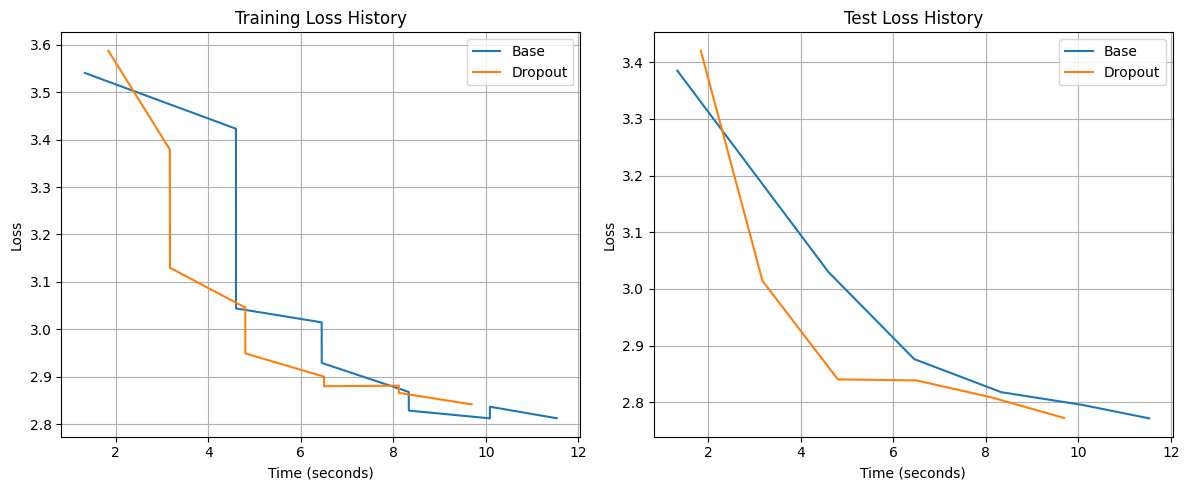

In [ ]:
# plot the loss history
plt.figure(figsize=(12, 5))

# -------------------------
# Left plot: TRAINING LOSS
# -------------------------
plt.subplot(1, 2, 1)
plt.plot(base_time_hist, base_loss_hist, label="Base")
plt.plot(dropout_time_hist, dropout_loss_hist, label="Dropout")
plt.xlabel("Time (seconds)")
plt.xlim(0, 300)
plt.ylabel("Loss")
plt.title("Training Loss History")
plt.legend()
plt.grid(True)

# -------------------------
# Right plot: TEST LOSS
# -------------------------
plt.subplot(1, 2, 2)
plt.plot(base_time_test_hist, base_loss_test_hist, label="Base")
plt.plot(dropout_time_test_hist, dropout_loss_test_hist, label="Dropout")
plt.xlabel("Time (seconds)")
plt.xlim(0, 300)
plt.ylabel("Loss")
plt.title("Test Loss History")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [20]:
def inference(model, params):
    B = 1
    seed = 42
    rng = jax.random.PRNGKey(seed)
    prompt = "hello my fri"
    # prompt_int = encode(prompt.lower())
    prompt_int = jnp.array([ [char_to_int.get(c, len(char_set)) for c in prompt.lower()[:64]] ], dtype=jnp.int32)

    gen_len = 1000
    out_ids = generation.generate_tokens(model, params, rng, prompt_int, gen_len, block_size=64,
                            temperature=0.7, sample=True)
    print('generated ids shape:', out_ids.shape)
    print('generated text:')
    generated_text = ''.join(int_to_char.get(int(x), '?') for x in list(out_ids[0]))
    # concatenate with prompt
    print(prompt + generated_text)
    #print(''.join(int_to_char.get(int(x), '?') for x in list(out_ids[0])))

In [ ]:
inference(base_model, base_model_params)
inference(dropout_model, dropout_model_params)

generated ids shape: (1, 1000)
generated text:
hello my frixxemclczwwo weelelw hokizeromrzleciiwwmzerbhzffrpmeszzczzwrecrnezrczmeeirf mzyoerueroozrel  eor r  werz ferrr  rremerdrrlrry kmrrrxrr rrrrdrf  rrrrmrrrrmmrrr krazrrrrrrrrrrruzrrrrrwrrrrybmzrrrr krrorrrrrrrrrrfrerrrrrrrrrrrrrrrrrdrzprrqrrrrzrzrrrngrrrrrmrerrrrrqrrrwrnrrrrrrmrrertmrrr rs irrrrbrr rrrrrrrrrrrqrrrfrsrekrrrzrtrrrzrrr  eerrrsfrrrrrrrrrrrrrrrs  zserxrrrrqr rrr rrarzrbrr  krrrsimrwrlr wrrrrrrkrrrr rhrrhredrfzrrrrbrr rrrherwrirxrmrrrrrrrnrrrrririrzarzrrrmarrrjlihmrrbjrtrrrrrrrbrrrrhfesexrkxrrrhrrerrrrriirirnrrrxhrrmrf q z em gr  j zrrrzzaxzrfzlzraurr rl szrrrr ruzrf hwirvrr cryrrktprrrrecr rynirerrzirh frrrumrhkzurrr rrngrrrgrer ramrrnmvrrowlrzrrerzlrrhzrrrrrrrzrryrlrfzrrrrrhrrerrezrrzrfnrfrrrrorrfwirzirprrbrrrrswqrrrlerzrrrrrrkrrzrziilrzrrrkrzrkrrzrrbwjsrrrrrr  enrrrkirparr zrwsr crwrzrrrykrfmbrrrrkgrrrr  rbrrlrror kryrrrnmrrrrrrrmzrkrbrrtirrrgrrmrrrrrrrhorrrrrrqrwsrrrnhrrrrrkrnhrvrereirrr  kwtzr r wtzrreirsjnrroabwrrr